# Retrieve SDSS Cutouts for a Bunch of RA,DEC pairs #

The goal is to retrieve the SDSS color image for a particular pointing, given a collection of RA and Dec values.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
#from astropy.cosmology.funcs import distmod
from astropy.cosmology import WMAP9 as cosmo
from astropy.constants import c
from astropy import units as u
import warnings 
warnings.filterwarnings('ignore')
from pydl.pydlutils.spheregroup import spheregroup

In [3]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table

In [4]:
try:
    # Python 3.x
    from urllib.parse import urlencode
    from urllib.request import urlretrieve
except ImportError:
    # Python 2.x
    from urllib import urlencode
    from urllib import urlretrieve

In [5]:
import IPython.display

In [6]:
table_path = '/Users/rfinn/Dropbox/Research/APPSS/SDSSphot/run_sep14/'
latest_run = 'a100.code12.SDSSvalues170914.csv'
agc_cross = 'a100.sdsscross.code12.170914.csv'
HI = 'a100.code12.tab1.170914.csv'

In [33]:
infile = table_path+latest_run
sdss = np.recfromcsv(infile)
infile = table_path+latest_run
agc = np.recfromcsv(table_path+agc_cross)
HI = np.recfromcsv(table_path+HI)

In [34]:
HI.dtype.names

('agcnr',
 'name',
 'radeg_hi',
 'decdeg_hi',
 'radeg_oc',
 'decdeg_oc',
 'vhelio',
 'w50',
 'errw50',
 'hiflux',
 'errflux',
 'snr',
 'rms',
 'dist',
 'logmsun',
 'hicode')

In [53]:
keepflag = (sdss['ra']> 150.) & (sdss['ra'] < 225.) & (sdss['objid'] > 12) & (agc['sdss_z'] == agc['sdss_z'])& (agc['sdss_z'] < 0.05)
ra = sdss['ra'][keepflag]
dec = sdss['dec'][keepflag]
z = agc['sdss_z'][keepflag]

## Locate Galaxy Groups ##

I took this code from John Moustakas

https://github.com/legacysurvey/legacypipe/blob/master/doc/nb/legacysurvey-gallery-groups-dr5.ipynb

**Some Info on what spheregroup returns**

* grp = group number
* mult = number of galaxies in each group

In [54]:
linking_length = 10. # arcmin

In [55]:
%time grp, mult, frst, nxt = spheregroup(ra, dec, linking_length/60.)

CPU times: user 4.35 s, sys: 12.3 ms, total: 4.36 s
Wall time: 4.36 s


In [37]:
npergrp, _ = np.histogram(grp, bins=len(grp), range=(0, len(grp)))
nbiggrp = np.sum(npergrp > 1).astype('int')
nsmallgrp = np.sum(npergrp == 1).astype('int')
ngrp = nbiggrp + nsmallgrp

In [38]:
print('Found {} total groups, including:'.format(ngrp))
print('  {} groups with 1 member'.format(nsmallgrp))
print('  {} groups with 2-5 members'.format(np.sum( (npergrp > 1)*(npergrp <= 5) ).astype('int')))
print('  {} groups with 5-10 members'.format(np.sum( (npergrp > 5)*(npergrp <= 10) ).astype('int')))
print('  {} groups with >10 members'.format(np.sum( (npergrp > 10) ).astype('int')))

Found 9737 total groups, including:
  7188 groups with 1 member
  2453 groups with 2-5 members
  88 groups with 5-10 members
  8 groups with >10 members


## Get Group Numbers ##

Get the group ids for groups greater than 10 members

In [56]:
lg_groups = np.where(mult > 10)
print lg_groups

(array([1967, 2003, 3191, 3491, 3592, 4035, 7361, 7613]),)


## Get Members of Each Group ##


In [57]:
member_ids=[]
for gid in lg_groups[0]:
    #print gid
    newlist = np.where(grp == gid)
    #print newlist
    member_ids.append(newlist)

for ids in member_ids:
    print ids[0]

[2749 2776 2780 2781 2791 2796 2804 2825 2827 2846 2848 2851 2854 2863 2898
 2916 2925 2934 2961]
[2798 2812 2829 2834 2860 2869 2895 2904 2924 2943 2965]
[4625 4640 4673 4678 4684 4709 4715 4733 4772 4780 4794 4832 4848 4853 4875]
[5061 5077 5089 5103 5105 5106 5109 5114 5117 5120 5123 5124 5139 5140 5145
 5150 5157 5179]
[5222 5236 5243 5247 5259 5265 5282 5289 5290 5299 5300 5311 5345 5362]
[5867 5880 5881 5897 5899 5903 5913 5914 5919 5933 5934]
[10583 10603 10611 10622 10624 10626 10629 10636 10638 10644 10651 10652]
[10939 10949 10958 10974 10981 10983 10986 10991 10996 11000 11001 11004
 11008 11017 11020 11027 11030 11031 11049]


## Plot RA and Dec for Group Members ##

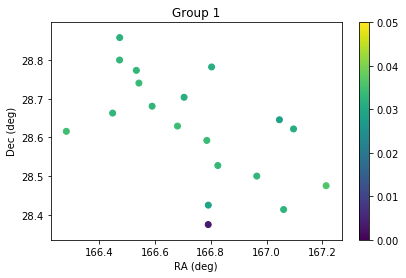

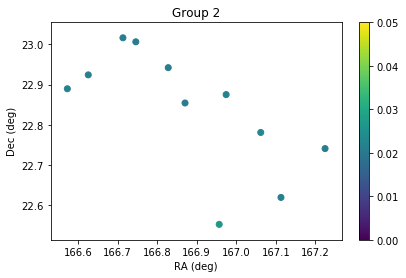

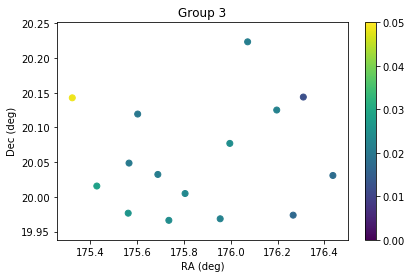

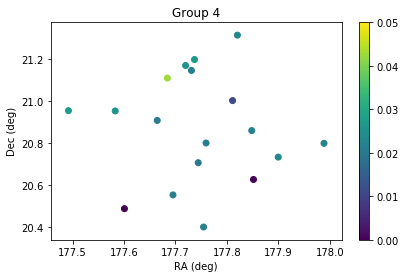

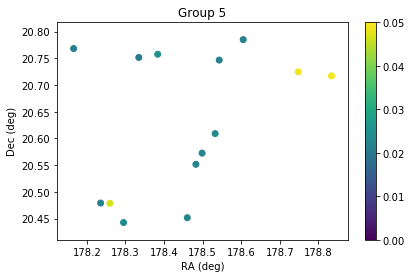

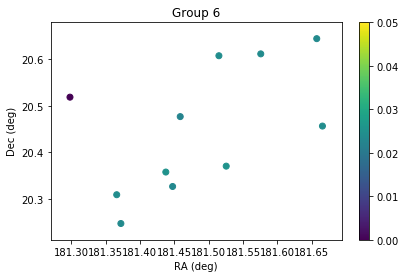

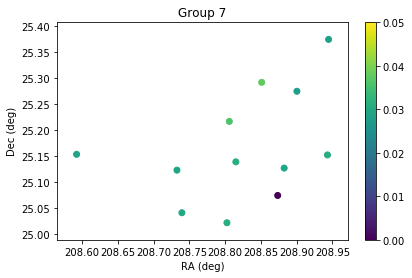

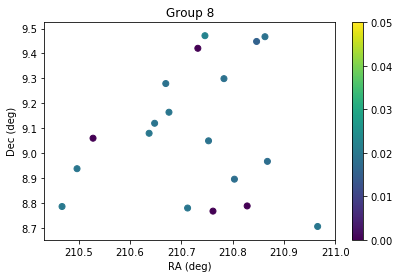

In [58]:
for i in range(len(member_ids)):
    plt.figure()
    plt.title('Group %i'%(i+1))
    plt.scatter(ra[member_ids[i][0]],dec[member_ids[i][0]],c = z[member_ids[i][0]],vmin=0,vmax=.05)
    s = plt.colorbar(fraction=0.08)
    plt.xlabel('RA (deg)')
    plt.ylabel('Dec (deg)')
    

## Now dowload an image for each group ##

In [48]:
# try getting picture for first group with more than 10 members

ragroup = ra[npergrp > 10]
decgroup = dec[npergrp > 10]
groupnumber = grp[npergrp > 10]
print groupnumber


[1439 1439 2293 2499 2583 2828 5165 5370]


In [45]:
testcoord = SkyCoord(ragroup[0]*u.deg, decgroup[0]*u.deg, frame='icrs')

impix = 1024
imsize = 20*u.arcmin
cutoutbaseurl = 'http://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx'
query_string = urlencode(dict(ra=testcoord.ra.deg, 
                                     dec=testcoord.dec.deg, 
                                     width=impix, height=impix, 
                                     scale=imsize.to(u.arcsec).value/impix))
url = cutoutbaseurl + '?' + query_string

# this downloads the image to your disk
urlretrieve(url, 'group0_SDSS_cutout.jpg')

('group0_SDSS_cutout.jpg', <httplib.HTTPMessage instance at 0x11f036560>)

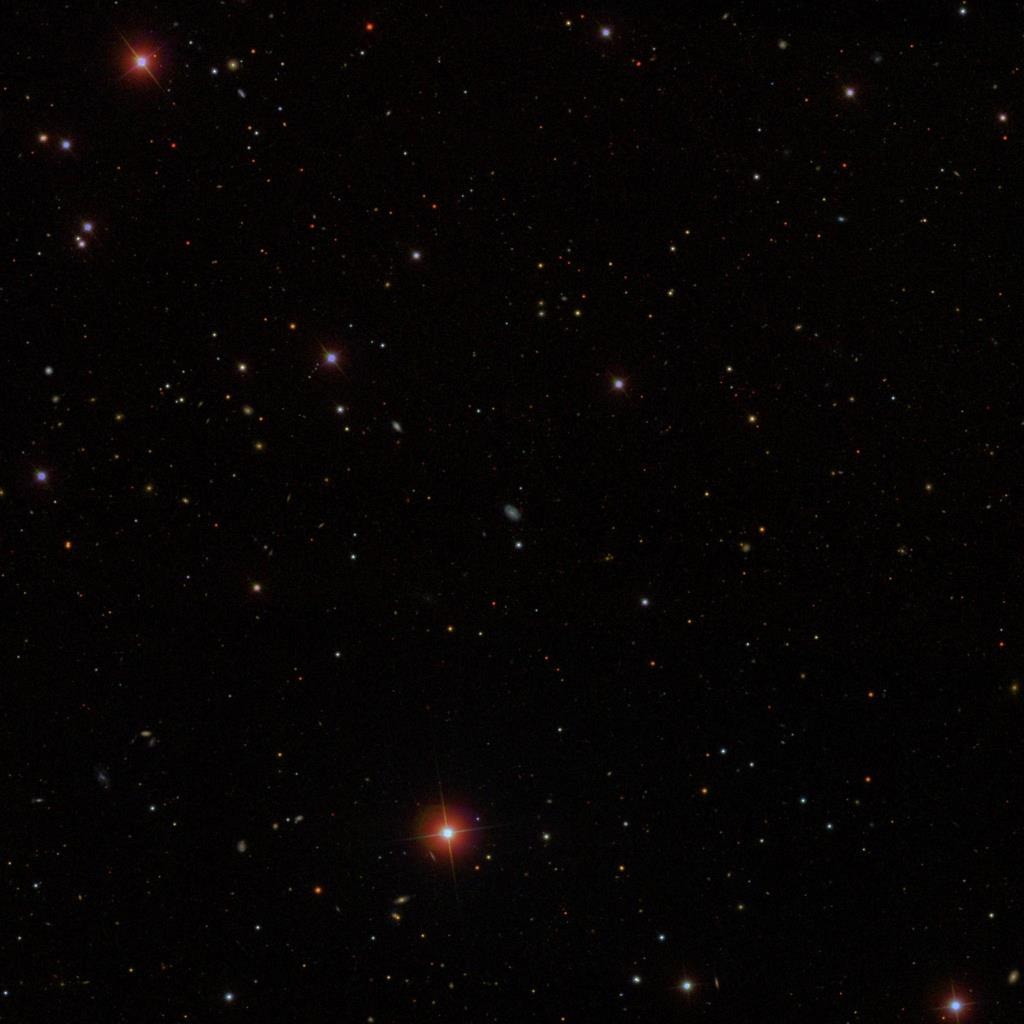

In [46]:
IPython.display.Image('group0_SDSS_cutout.jpg')


## plot sky positions of group members ##

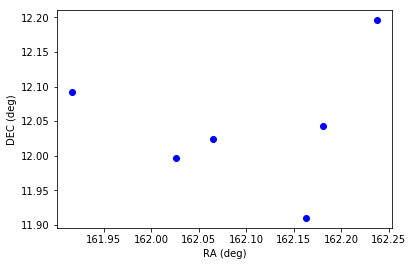

In [51]:
plt.figure()
plt.plot(ra[grp == 1439],dec[grp == 1439],'bo')
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')